This notebook demonstrates basic CF ensemble learning

Reference
1. `demo-stacking.ipynb` 
2. [Generate synthetic datasets that are harder to classify correctly](https://github.com/faizanahemad/data-science/blob/master/exploration_projects/imbalance-noise-oversampling/Generating%20and%20Visualizing%20Classification%20Data%20using%20scikit.ipynb)
3. [Why is imbalanced classification hard?](https://machinelearningmastery.com/imbalanced-classification-is-hard/)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import pandas as pd
from pandas import DataFrame
import os, sys

# Tensorflow
# import tensorflow as tf
# import tensorflow_probability as tfp
# tfd = tfp.distributions
# tf.executing_eagerly()

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

from tqdm import tqdm

### Configure system environment
- Please modify `input_dir` according to your local enviornment

In [ ]:
cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

Mounted at /content/drive
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble']


### Import classifers and utilities

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics._classification import cohen_kappa_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as us
import scipy.sparse as sparse

np.set_printoptions(precision=3, edgeitems=5, suppress=True)

### Generate data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


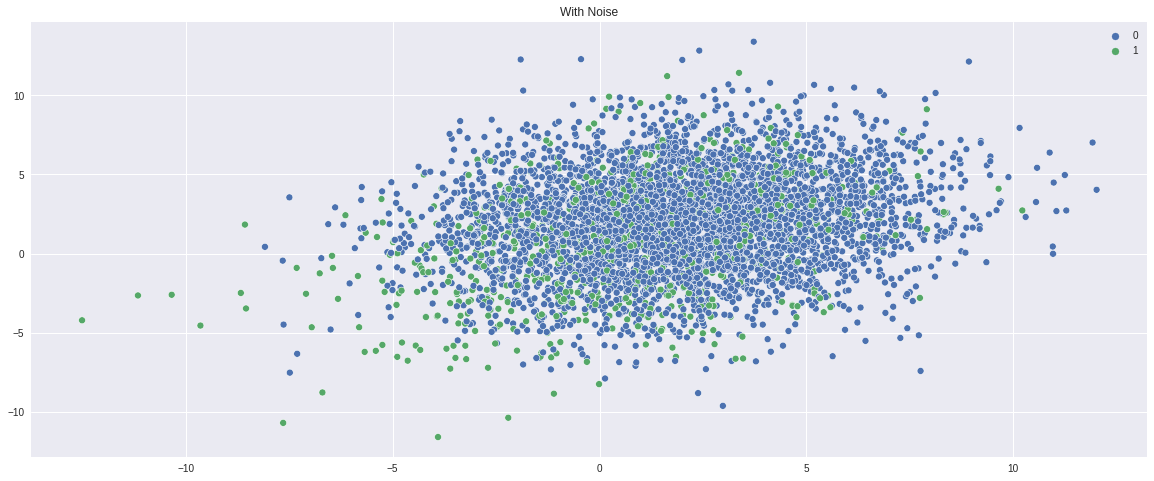

> n_classes: 2
[0 1]

> counts:
Counter({0: 4297, 1: 703})



In [ ]:
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from collections import Counter

# get the dataset
def get_dataset(n_samples=5000, noise=True):
    if noise: 
        X,y = make_classification(n_samples=n_samples, n_features=100, n_informative=30, 
                        n_redundant=6, n_repeated=3, n_classes=2, n_clusters_per_class=1,
                            class_sep=2,
                            flip_y=0.2, # <<< 
                            weights=[0.95], random_state=17)
    else: 
        X,y = make_classification(n_samples=n_samples, n_features=100, n_informative=30, 
                            n_redundant=6, n_repeated=3, n_classes=2, n_clusters_per_class=1,
                                class_sep=2, 
                                flip_y=0, weights=[0.95], random_state=17)
    return X, y

#######################################
# X, y = load_iris(return_X_y=True) # too easy
# X, y = uclf.generate_gaussian_quantiles(n_samples=5000) # too easy
X, y =  get_dataset(noise=True)

# Plot data
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
ax1.set_title("With Noise");
plt.show();

uniq_labels = np.unique(y)
n_classes = len(uniq_labels)

# Turn into a binary classification problem 
if n_classes > 2: 
    print('> y before:\n', y)
    y, y_map, le = uclf.to_binary_classification(y, target_class=2)
    print('> y after:\n', y)

print(f'> n_classes: {n_classes}\n{uniq_labels}\n')

counter = Counter(y)
print(f'> counts:\n{counter}\n')

### Define base models
- SVC
  - Set `probability` to True to enable probability estimates. This must be enabled prior to calling `fit(...)`, will slow down that method as it internally uses 5-fold cross-validation, and `predict_proba` may be inconsistent with predict.

In [ ]:
# Create Base Learners
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

### Run CF stacker

Todo
  - implement a **CF ensemble method** and assign it to `final_estimator` 

In [ ]:
from sklearn.metrics import f1_score

n_iter = 1

cf_stackers = []
for i in range(n_iter): 
    # Initialize CF Stacker
    print(f"[info] Instantiate CFStacker #[{i+1}] ...")
    clf = ustk.CFStacker(estimators=base_learners, 
                            final_estimator=LogisticRegression(), 
                            work_dir = input_dir,
                            fold_number = i, # use this to index traing and test data 
                            verbose=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    clf.fit(X_train, y_train)

    X_meta_test = clf.transform(X_test)
    print(f"[info] shape(X_meta_test): {X_meta_test.shape}")

    y_pred = clf.predict(X_test)
    perf_score = f1_score(y_test, y_pred)  # clf.score(X_test, y_test)
    print('[result]', perf_score)

    # Add test label for the convenience of future evaluation after applying a CF ensemble method
    clf.cf_write(dtype='test', y=y_test)

    # keep track of all the stackers (trained on differet parts of the same data as in CV or resampling)
    cf_stackers.append(clf)


[info] Instantiate CFStacker #[1] ...


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


(BaseCF) base est | name: RF, estimator: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
(BaseCF) base est | name: KNNC, estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')
(BaseCF) base est | name: GNB, estimator: GaussianNB()
(BaseCF) base est | name: QDA, estimator: QuadraticDiscriminantAnalysis()
(BaseCF) base est | name: MLPClassifier, estimator: MLPClassifier(alpha=1, max_iter=1000)
(BaseCF) Base predictors:
[1]  RF: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
[2]  QDA: QuadraticDiscriminantAnalysis()
[3]  MLPClassifier: MLPClassifier(alpha=1, max_iter=1000)
[4]  KNNC: KNeighborsClassifier(n_neighbors=2, weights='distance')
[5]  GNB: GaussianNB()




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

[info] Saving X_meta (shape=(3750, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/train-0.npz

[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[info] shape(X_meta_test): (1250, 5)
[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[result] 0.5101214574898785
(cf_write) Adding new attribute y:
[0 0 0 0 1 ... 0 1 0 0 0]
...
(cf_write) Saving X_meta at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz



### Probability thresholds of base classifers
- A binary classifier produces conditional probability estimates P(Y=1|X). Given a threshold (e.g. 0.5), the classifier predicts positive if P(Y=1|X) is equal or larger than this threshold; negative otherwise. 
- Given a performance matrix, say F1 score, there is an optimial threshold that leads to a maximum performance score; for F1, we call this an Fmax.
- Each base classifier has its own probability threshold.
- By convention in CF-ensemble modules, `R` is used to denote the probability (rating) matrix for the training set whereas `T` is used to denote the probability matrix for the test set. 
   - `R`, of course, came from the notion of 'rating'. Probability scores are likened to ratings in recommender system in that they can be thought of as quantifying how "preferable" for us to conclude a training instance `x` being positive (versus negative).
   - In most ML convention, however, feature vectors are represented in column-vector format; when you see (X, y), X[:, i] usually represents a single training instance while y[i] is its corresponding label. 
   - In collaborative filtering (CF) and CF-based ensemble methods, a matrix in **users x items** format may be better interpreted and therefore it is the convention that's being used in CF code
   - `R` corresponds to `X_train.T`
   - `T` corresponds to `X_test.T`

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=6c0fc56be4e9a30bdac05267bc731c90354334e5d38fa52a6f066d9f03ffa79b
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
[info] list of base classifiers:
RF, KNNC, GNB, QDA, MLPClassifier

Recall                  Baseline: 1.0                  Test: 0.36                  Train: 0.32
Precision                  Baseline: 0.14                  Test: 0.89                  Train: 0.9
Roc                  Baseline: 0.5                  Test: 0.66                  Train: 0.66


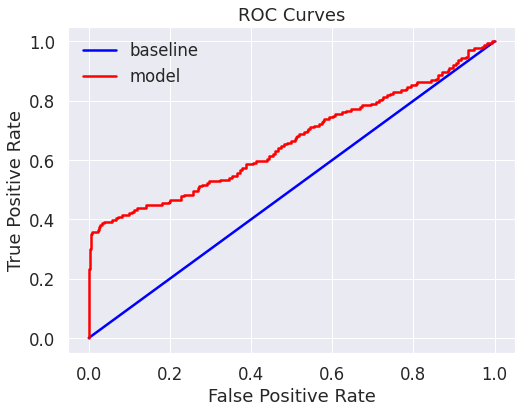

In [ ]:
import utils_cf as uc 
from utils_classifier import evaluate_model
from utils_sys import format_list

fold_number = 0 # called `fold_number` because we usually instantiate multiple CFStackers in a CV or resampling loop

# Instantiate a new CFStacker if you do not wish to spend time training base classifiers above
# ... this is ok assuming that pre-trained level-1 datasets are available under ./data
try: 
    clf = cf_stackers[fold_number]
except: 
    print("[info] Instantiating a new instance of CFStacker bypassing training loop (assuming pre-trained data available) ...")
    clf = ustk.CFStacker(estimators=base_learners, 
                        final_estimator=LogisticRegression(), 
                        work_dir = input_dir,
                        fold_number = fold_number, # use this to index traing and test data 
                        verbose=1)
    
# Load pre-trained level-1 data
meta_set = clf.cf_fetch()
X_train, y_train = meta_set['train']['X'], meta_set['train']['y'] 
X_test = meta_set['test']['X']
y_test = None
try: 
    y_test = meta_set['test']['y']
except: 
    print("[warning] test label is not available yet. Run the previous code block first.")

# Names of the base classifiers/predictors/estimators
U = meta_set['train']['U']
print(f"[info] list of base classifiers:\n{format_list(U)}\n")

# Performance under stacking 
# Note that ROC is not recommended for class-imbalanced datasets; use precision-recall curve and F-beta instead)
if y_test is not None and hasattr(clf, 'final_estimator_'): # then we must have executed the previos block in which CF stacker was trained
    y_prob_train = clf.final_estimator_.predict_proba(X_train)[:, 1] # conditional probability for training set
    y_pred_train = clf.final_estimator_.predict(X_train) # label prediction for training set
    y_prob = clf.final_estimator_.predict_proba(X_test)[:, 1]
    y_pred = clf.final_estimator_.predict(X_test)
    evaluate_model(train=(y_train, y_pred_train, y_prob_train), test=(y_test, y_pred, y_prob)) 



### Basic definitions (before moving further)

- Given probability thresholds (`p_th`), base predictors can now produce positive (1) and negative (0) label predictions
- The output of base predictors form a matrix of conditional probabilities (`X`); by convention, we organize this matrix in the shape `n_classifiers` by `n_samples` (note that this is the transpose of sklearn's convention of representing the training data)
  - The training split of X is denoted by `R` (name adapted from rating matrix)
  - The test split of X is denoted by `T`  
- Assuming that the data distribution in the test set remains the same as the training set `R`, we can reuse the same thresholds for `T`, which allows us to turn T into a binary matrix of 0s and 1s. 
  - We use `L` to denote the label vector, which can be further split into `L_train` and `L_test`
     - In codes, `L_train` is sometimes denoted by `Lr` and `L_test` detnoted by `Lt`
  - Note that in the code, I had abused the notation `L` to mean either the **label vector** or the **label matrix** ('binarized' verison of R and T given probability thresholds `p_th`) depending on the context. 
     - `Lh`, on the other hand, denotes an "estimated" label matrix (e.g. for test set where labels are assumed to be unknown) whereas `lh` is reserved for **estimated label vector**. These will all be clarified shortly within the next few code blocks. 

In [ ]:
from utils_sys import highlight

# Probability matrix (R, T) 
# Probability (rating) matrices, R or T, have a transpose relationship with
# standard feature vector representation in column vector format (like X_train, X_test)

# Structure the rating/probability matrix
highlight("R: Rating/probability matrix for the TRAIN set")
R = X_train.T # transpose because we need users by items (or classifiers x data) for CF
L_train = y_train

# Similarly, ...
# T = X_test.T
# L_test = y_test

assert R.shape[1] == len(y_train)
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax') 
print(f"> Probability thresholds:\n{p_threshold}\n")
assert len(p_threshold) == R.shape[0], \
          f"Each classifier/user should have his/her own threshold (n_classifiers={R.shape[0]})"

print()
#########################################################
highlight("T: Rating/probability matrix for the TEST set")

T = X_test.T
lh = uc.estimateLabels(T, L=[], p_th=p_threshold, pos_label=1) # "majority vote given proba thresholds" is the default strategy

n_users = T.shape[0]
test_idx = np.random.choice(range(T.shape[1]), 10)
for j, tid in enumerate(test_idx): # foreach datum 
    print(f"> base proba:       {T[:,j]}")
    lv = np.where(T[:,j] >= p_threshold, 1, 0)
    print(f"> label vector:    {lv}")
    print(f"> estimated label: {lh[j]}") # estimated labeling by majority
    print()

R: rataing/probability matrix for the TRAIN set
(estimateProbThresholds) policy: fmax
> Probability thresholds:
[0.497 0.533 0.881 1.    0.62 ]


T: rataing/probability matrix for the TEST set
> base proba:       [0.5   0.    0.003 0.    0.014]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.    0.002 0.    0.04 ]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.    0.004 0.    0.006]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.    0.01  0.05  0.012]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.494 0.    0.    0.09 ]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.    0.009 0.    0.009]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.    0.001 0.    0.007]
> label vector:    [1 0 0 0 0]
> estimated label: 0

> base proba:       [0.5   0.499 0.077 0.    0.042]
> label vector:    [

### Probability filter  
- A *probability filter* (P) is a binary matrix where 1 indicates a "reliable probability" and 0 indicates an unreliable probability. P can be defined as a function of L but exactly what kind of function depends on our filtering policy (i.e., how we measure reliability)
  - `P` allows us to select relevant entries that contribute to the CF optimization objective to compute latent factors
     - In principle, we want to retain only those entries corresponding to TPs and TNs
     - (Thought) Perhaps wrong probabilties have information as well; we could associate "negative weights" to wrong probabilities so that the latent factors will try to steer away from the wrong value
  - For the training set, since we know the true label (`y_true`), we can adopt a simple strategy for `P`: Given a data point j, for all base predictors i, if `L[i,j]` is consistent with `y_true[j]`, then `P[i,j]` = 1; otherwise, `P[i,j]` = 0
  - For the test set, we do not know the true label (what we aim to predict); we need to guesstimate the label (`L_test`). Majority vote is only one possible strategy (but we need to do better than this).
    - Note that, in the code, `lh` is often used to denote "estimated" labels for T (therefore, they need not be all correct but they are necessary for deriving latent factors). 
    - We need a method to somehow estimate the `Lh` (estimated labeling matrix) for T, from which we can then decide which entries to keep while the others are considered "missing values" to be re-estimated by latent factors.
- Probility filter is sometimes refered to as **preference matrix** in the code. 
- Probability filter is strongly related to **polarity matrix** and **color matrix**. In fact, they are simply two variations of probability filters with different encodings for reliable and unreliable entries. They will be introduced shortly a couple of blocks down. 
  - You may wonder why we defined so many different types of matrices. Ultimately, we need a mathmatical device to help us select desirable entries (ratings) while filtering unwanted entries (analogous to missing values) toward constructing our optimization objective for computing latent factors. Additionally, each element in a probability matrix (base predictor output) often has a different degree of reliability. This leads to the notion of **confidence score** associated with each prediction from base predictors. 
     - Polarity matrix and color matrix both help to define *confidence matrix* (to be introduce next); and they were introduced mainly in the context of *polarity modeling*, which is probably too complex for ensemble learning purposes (see `uc.polarity_modeling`). I don't recommend using polarity modeling at the moment; nonetheless, these matrix definitions are still helpful. 
     - If the probability filter is defined through a polarity matrix, it's often denoted by `Po`; if defined through a color matrix, it's denoted by `Pc`. It's intended to be consistent throughout the code.

In [ ]:
# Label matrix for the training (Lr) and the test set (Lt)
Lr = uc.estimateLabelMatrix(R, p_th=p_threshold)
Lt = uc.estimateLabelMatrix(T, p_th=p_threshold)

cutoff = 10 # choose a cutoff so that we don't need to worry about displaying big 2D arrays
print(f"> Lr (shape={Lr.shape}):\n{Lr[:, :cutoff]}\n") # Convert probability scores to corresponding label predictions given thresholds
print(f"> Lt (shape={Lt.shape}):\n{Lt[:, :cutoff]}\n") 

#########################################################
# Note that the label matrix itself is NOT a probability filter, it needs to be 
# compared to the label (for R, the labels are the gold standard; for T, the "labels"
# refer to the guesstimated labels e.g. via majority vote, nearest neighbors)

# Probability filter can be implemented through polarity matrix 
# >>> probability filter always depends on the label (true or guessed) and the probability threshold
Po_tr, Lr2 = uc.polarity_matrix(R, L_train, p_threshold) # L_train is the true label
assert np.sum(Lr != Lr2) == 0, "Lr and Lr2 from polarity matrix should be identical!"

Mr = uc.to_preference(Po_tr)
print(f"> Mr (shape={Mr.shape}):\n{Mr[:, :cutoff]}\n") 

lh = uc.estimateLabels(T, p_th=p_threshold) # We cannot use L_test (cheating), but we have to guesstimate
Po, Lt2 = uc.polarity_matrix(T, lh, p_threshold) # lh is the guesstimated label
Mt = uc.to_preference(Po)
print(f"> Mt (shape={Mt.shape}):\n{Mt[:, :cutoff]}\n") 

> Lr (shape=(5, 3750)):
[[1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

> Lt (shape=(5, 1250)):
[[1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

> Mr (shape=(5, 3750)):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

> Mt (shape=(5, 1250)):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]



### Confidence matrix 
- As mentioned, a probability filter (P) is a 0-1 matrix, where       
   - 0 represents unrelilable predictions (FPs, FNs) and 1 represents reliable predictions (TPs, TNs)
     - Note that "unreliable" probability scores can often be equated to "incorrect" probabibilities (leading up to wrong predictions like FP, FN) but they need not be "wrong"; similarly, reliable probabilities are not necessarily "correct" but it's helpful to imagine them being correct (as TP, TN). 
   - It is helpful to think of unreliable probabilities as missing values (as they are in a rating matrix) because they will not enter the optimization objective later on for the purpose of deriving latent factors -- and they are to be re-estimated using reliable probabilities. 
- Confidence matrix (C) is a function of P
   - A confidence matrix is essentially a "weighted" probaiblity filter, where reliable predictions are given higher weights and unreliable probabilties are given either zero weights or negative weights (depending on the optimization strategy i.e. how we define the cost)
   - Reliabilty is quantified by a chosen confidence measure (e.g. Brier score)



In [ ]:
L = np.hstack((L_train, lh)) # true labels (for R) concatenated with estimated labels (for T)
X = np.hstack((R, T))
n_train = R.shape[1]
assert X.shape[0] == R.shape[0]
print(f"> Number of classifiers: {X.shape[0]}")
print(f"> size(R): {R.shape[1]}, size(test): {T.shape[1]} => size(X): {X.shape[1]}")

CX = uc.evalConfidenceMatrix(X, L=L, U=U, 
                             p_threshold=p_threshold, # not needed if L is given (suggested use: estimate L outside of this call)
                             policy_threshold='fmax',
                             conf_measure='brier', 
                             # alpha=1.0, beta=1.0,  # these parameters are now factored into `balance_and_scale()`
                        
                             fill=0, 
                             is_cascade=True, n_train=n_train,  # n_train serves as a cutoff that separates X into R and T when necessary

                            # Ignore all polarity matrix-related parameters 
                            # constrained=params.get('constrained', True),
                            # stochastic=params.get('stochastic', True),
                            # estimate_sample_type=params.get('estimate_sample_type', True),
                            # labeling_model=params.get('labeling_model', 'simple'),
                            # policy_polarity=params.get('policy_polarity', 'sequence'),

                            # for testing only
                            fold=0)  

> Number of classifiers: 5
> size(R): 3750, size(test): 1250 => size(X): 5000


(evalConfidenceMatrix) policy_filtering: item, policy_opt: rating | conf_measure: brier | policy_threshold: fmax, ratio_users: 0.5, ratio_small_class: 0, supervised? True, mask_all_test? False | alpha: 10


... Filtering policy in training split: item =?= test split: polarity
################################################################################
(evalConfidenceMatrix) labeling_model: simple | constrained? True, stochastic? True, est sample type? False
################################################################################
... Balance class | balance sample size distribution? False, balance class conf scores? False
... Posthoc weight adjustments? | beta: 1.0, suppress_negative_examples: False
(toConfidenceMatrix) List of proba thresholds given policy: fmax | sorted according to -- classifer -- 
... [1] GNB: p_th = 0.880888
... [2] KNNC: p_th = 0.532714
... [3] MLPClassifier: p_th = 0.61957

- Confidence matrix (C) is a function of raw confidence score matrix (C0) and polarity matrix (Po)
   - Polarity matrix is a binary matrix consisting of 1 and -1, where 1 corresponds to {TP, TN} and -1 corresponds to {FP, FN}
   - Define Cui as the element-wise product (or Hadamard product) between `C0` and `Po` such that TP and TN entries with high confidence scores are given high positive weights whereas FP and FN entries are given zero weights so that they do not enter the optimization objective
     - (Idea) We could instead assign FP and FN entries in R (and T) negative weights instead of zeros such that their re-estimated probabilties are made to move away from the wrong values. E.g. probablity scores for FPs must have been too big (bigger than `p_th`) and therefore, should be adjusted to sufficiently smaller values to the extent that FP turns into TN; similarly, FN turns into TP. It's unclear how to translate this "negative loss" into the existing optimization objective though (assigning negative weights is not enough. Why?).
     - Latent factors will make greater efforts in approximating the entries with relatively higher positive weights (because otherwise, their squared losses will be larger as a result of the larger weights)



In [ ]:
C0, Po, p_threshold, *CX_res = CX 
min_score, max_score = np.min(C0), np.max(C0)
print(min_score, max_score)

0.0 0.9077302149184947


In [ ]:
# set confidence scores for FP, FN (and entries with high uncertainty i.e. neutral) to 0 so that 
# they do not enter the optimization objective (i.e. latent factors do not care to approximate these entries well)
Cn = uc.mask_neutral_and_negative(C0, Po, is_unweighted=False, weight_negative=0.0, sparsify=True)
assert np.sum(Po < 0) == np.sum(Cn == 0)
Cn = uc.balance_and_scale(Cn, X=X, L=L, Po=Po, p_threshold=p_threshold, U=U, 
                    alpha=10.0, 
                        conf_measure='brier', 
                                n_train=n_train, fold=0, verbose=True)


(make_cn) Using UNWEIGHTED Cw, non-weighted MF to approximate ratings ...
(balance_and_scale) Balancing class weights by considering size disparity ...

(verify_confidence_matrix) Are the confidence scores taking on values as expected?


--------------------------------------------------------------------------------
(before) balanced + magnified (alpha=10.0, beta=1.0) | dtype: training set
--------------------------------------------------------------------------------

[verify] n(TP+TN): 18681, n(FP+FN): 6319, ratio: 0.74724

-- Class-wise weight distributions --
... Class Positive (+): min = 1.0, max = 1.0, mean = 1.0, median = 1.0
... Class Negative (-): min = 1.0, max = 1.0, mean = 1.0, median = 1.0

--- Confidence score (weight) sum total per class ---
... N(TP): 1557, N(TN): 17124, N(TP)/N(TN): 0.09092501751927119
... W(TP): 1557.0, W(TN): 17124.0, W(TP)/W(TN): 0.09092501751927119
... Balanced? W(TP)/W(TN)=0.09092501751927119 ~ 1.0


(verify_confidence_matrix) Have we masked the

### Other important quantities 
- Color matrix  
  - Each entry in a color matrix is an encoding of the four types: {TP, TN, FP, FN} 
  - Given a probability/rating matrix X, probability thresholds (of base predictors) and the (true) labels, we can determine the "particle type" of each probability score in X. An example, if X[2,5] = 0.7 and its associated classifier U[2] (that produces probability scores for X[2, :]) has a threshold of 0.5, then U[2] predicts X[2,5] to be positive; if the true label at position 5 is also positive, then we know that X[2,5] = TP, which is encoded as 2
     - By default, TP=2, TN=1, FP=-2, FN=-1 (see class Polarity in `utils_cf`)
- Polarity matrix
  - Polarity matrix can be thought of as a special case of coloar matrix, where {TP, TN} are encoded as 1 while {FP, FN} are encoded as -1
  - 1 simply represents "correct" probabilties, positive or negative
  - -1 represents "incorrect" probabilties
  - Correct or not of course depends on the threshold, which depends on the classifier and the data

Note that both color matrix and polarity matrix can contain 0s. 0 is reserved to represent uncertain entries i.e. entries with relatively high uncertainty -- so high we cannot reliably conclude their particle types. 

Note also that these matrices are ultimately designed to provide reasonable weights in the opimization objective (see the slides for now). The key quantity remains to be the **confidence matrix**, which can be determined by color matrix in polarity modeling approach (which we do not need to consider at the moment). 
   - You may find knowing particle types helpful in determining confidence matrix in your own models.

In [ ]:
# np.set_printoptions(precision=3, edgeitems=5, suppress=True)
from utils_cf import polarity_matrix, color_matrix
from utils_cf import estimateLabelMatrix, estimateLabels

# Probability thresholds 
R, T = X[:,:n_train], X[:,n_train:]
L_train = L[:n_train]
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax')

cutoff = 10

# Polarity matrix
print(f"> Probability matrix (R, shape={R.shape})") 
print(R[:cutoff])

print(f"> Probability thresholds (p_th, shape={p_threshold.shape})")
print(p_threshold); print() 

Lh = estimateLabelMatrix(R, p_th=p_threshold)
Lh2 = np.where(R >= np.array(p_threshold)[:, None], 1, 0)
assert np.sum(Lh != Lh2) == 0, "Lh and Lh2 should be identical"

print(f"> Label matrix (Lh, shape={Lh.shape})") # Convert probability scores to corresponding label predictions given thresholds
print(Lh[:, :cutoff]) 

lh = estimateLabels(R, p_th=p_threshold) # Reduce Lh to a label vector via a given policy (e.g. majority vote)
print(f"> Label vector (lh, shape={lh.shape}) by taking majority vote across classifiers (axis=0)") # lh is NOT the same as Lh
print(lh[:cutoff])

print("> True labels")
print(L_train[:cutoff])

print('-' * 80)
Po, Lh = polarity_matrix(R, L_train, p_threshold) # {TP, TN}: 1, {FP, FN}: -1
assert Po.shape == R.shape
print(f"> Polarity matrix (Po, shape={Po.shape})")
print(Po[:, :cutoff])

Pc, Lh2 = color_matrix(R, L_train, p_threshold)
assert np.sum(Lh != Lh2) == 0, "Lh and Lh2 should be identical"
print(f"> Color matrix (Pc, shape={Pc.shape}) is like polarity matrix but also differentiates TP, TN, FP, FN")
print(Pc[:, :cutoff])

(estimateProbThresholds) policy: fmax
> Probability matrix (R, shape=(5, 3750))
[[0.497 0.497 0.497 0.497 0.497 ... 0.5   0.5   0.5   0.5   0.5  ]
 [0.498 0.    0.    0.    0.    ... 0.    0.    1.    0.    0.   ]
 [0.014 0.011 0.045 0.028 0.243 ... 0.016 0.004 1.    0.005 0.03 ]
 [1.    1.    1.    0.994 1.    ... 0.    0.    1.    0.    1.   ]
 [0.029 0.003 0.301 0.03  0.001 ... 0.054 0.001 0.999 0.037 0.012]]
> Probability thresholds (p_th, shape=(5,))
[0.497 0.533 0.881 1.    0.62 ]

> Label matrix (Lh, shape=(5, 3750))
[[1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
> Label vector (lh, shape=(3750,)) by taking majority vote across classifiers (axis=0)
[0 0 0 0 0 0 0 0 0 0]
> True labels
[0 0 0 0 0 0 0 0 0 1]
--------------------------------------------------------------------------------
> Polarity matrix (Po, shape=(5, 3750))
[[-1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1. -1.  1. -1.]
 [

### Optimization [todo]
- Alternate least square (ALS)

In [ ]:
import utils_als as ua
from analyzer import is_sparse, is_binary, is_multivalued

# Uncomment the following to load pre-trained data if starting the notebook from here
# X, L, U, p_threshold, n_train = ustk.get_pretrained_model(input_dir, base_learners, fold_number=fold_number, verbose=1)

R, T = X[:,:n_train], X[:,n_train:]
print(R.shape, T.shape, X.shape)

n_factors = 20
n_iter = 100
alpha = 100.0
beta = 1.0 

assert X.shape[1] == R.shape[1]+T.shape[1]
assert len(L) == X.shape[1], f"Size of labels {len(L)} <> sample size: {X.shape[1]}"
assert len(U) == X.shape[0], f"Inconsistent number of users/classifiers: {len(U)} <> X.shape[0]: {X.shape[0]}"

# Earlier, we've obtained the following to get initial confidence matrix C0 and 
# its masked version Cn
"""
Setting up confidence Matrix.  

Key Parameters 
--------------
X: probabilty/rating matrix, X=[R|T]
L: labels (including the guesstimated labels associated with T)

p_threshold: 
policy_threshold: 'fmax'; this determines how `p_threshold` is estimated

conf_measure: Measure of reliabliity (of probability scores)

alpha: The factor by which confidence scores in C0 is to be scaled 
        in the latent-factor optimization objective
beta: The factor by which TP-specific confidence scores are amplified (
      so that these terms are penalized more severely in the cost function,
      if not approximated well)

"""
########################################################################
CX = uc.evalConfidenceMatrix(X, L=L, U=U, 
                             p_threshold=p_threshold, # not needed if L is given (suggested use: estimate L outside of this call)
                             policy_threshold='fmax',
                             conf_measure='brier', 
                             # alpha=10.0, beta=1.0, # this is now factored into `balance_and_scale`
                             fill=0, is_cascade=True, n_train=n_train, 
                             fold=0, 
                             verbose=0) 
C0, Pc, p_threshold, *CX_res = CX
Cn = uc.mask_neutral_and_negative(C0, Pc, is_unweighted=False, weight_negative=0.0, sparsify=True)
Cn = uc.balance_and_scale(Cn, X=X, L=L, Po=Pc, p_threshold=p_threshold, U=U, 
                    alpha=alpha, 
                        conf_measure='brier', 
                                n_train=n_train, fold=0, verbose=0)
# Cn = uc.shift(Cn, -1.0)
############################################################

# Now we will derive latent factors given the masked confidence matrix Cn (i.e. C0 with unreliable probabilities masked)
codes = particle_types = np.unique(Pc.A if is_sparse(Pc) else Pc)
print(f"[info] Number of unique codes: {len(codes)}\n{particle_types}\n") 

P, Q, *Xh_errs = ua.implicit_als(Cn, features=n_factors, 

                        iterations=n_iter,
                        lambda_val=0.8,  # 0.8 by default

                        # label_confidence=Cx_bar, 
                        polarity=None,  # None or pass in Pc: color matrix
                        p_threshold=p_threshold,
                        # positive_pref=1.0, 
                        # negative_pref=0.0, 

                        ratings=X, labels=L,
                        policy='rating', 
                        message='', 
                        ret_rmse=True)
Xh_err, Xh_err_weighted = Xh_errs
# print(f"[info] size(errors): {len(Xh_err)}\n{Xh_err}\n")
# print(Xh_err_weighted)

# Save latent factors because they are somewhat time-consuming to compute
clf.cf_write(dtype='test', P=P, Q=Q, losses=Xh_err) # save latent factor to the test set because they are ultimately used to predict test set

(5, 3750) (5, 1250) (5, 5000)
(make_cn) Using UNWEIGHTED Cw, non-weighted MF to approximate ratings ...
[info] Number of unique codes: 4
[-2. -1.  1.  2.]

(implicit_als) iteration policy: rating | L given? True | ret training error? True | n_iter=100, lambda=0.8 | caller msg: 
ImplicitMF> Optimization Policy: rating
(ALS) Solving for USER vectors via iteration | iteration 1 of 100 ...
(ALS) Solving for ITEM vectors via iteration | iteration 1 of 100 ...
(ALS) Solving for USER vectors via iteration | iteration 11 of 100 ...
(ALS) Solving for ITEM vectors via iteration | iteration 11 of 100 ...
... iteration 11 finished in 16.526575 seconds ...
...... iter: 10 | RMSE: 0.018199 | WRMSE: 0.173390 | decreasing (-)? (delta: -0.001317, delta_w: -0.017121)
(ALS) Solving for USER vectors via iteration | iteration 21 of 100 ...
(ALS) Solving for ITEM vectors via iteration | iteration 21 of 100 ...
... iteration 21 finished in 16.652098 seconds ...
...... iter: 20 | RMSE: 0.011044 | WRMSE: 0.095

Plot loss. Does the loss continues to decrease over iterations?

> Min(RMSE): 0.0032205349649596644


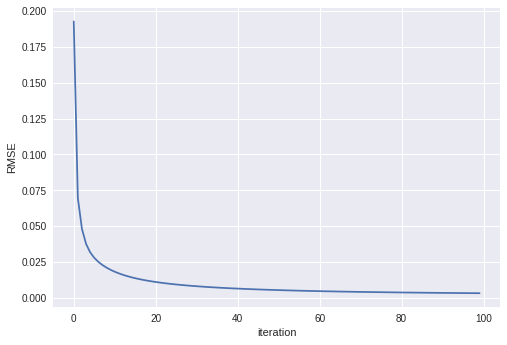

In [ ]:
from pandas import DataFrame

dfl = DataFrame({'RMSE': Xh_err, 'iteration': range(n_iter)})
sns.lineplot(data=dfl, x="iteration", y="RMSE")
print(f"> Min(RMSE): {np.min(Xh_err)}")

#### Re-estimating probability matrix R and T
- Denote reestimated `R` as `Rh` and reestimated `T` as `Th`


In [ ]:
fold_number = 0

# Instantiate a new CFStacker if you do not wish to spend time training base classifiers above
# ... this is ok assuming that pre-trained level-1 datasets are available under ./data
try: 
    clf = cf_stackers[fold_number]
except: 
    print("[info] Instantiating a new instance of CFStacker bypassing training loop (assuming pre-trained data available) ...")
    clf = ustk.CFStacker(estimators=base_learners, 
                        final_estimator=LogisticRegression(), 
                        work_dir = input_dir,
                        fold_number = fold_number, # use this to index traing and test data 
                        verbose=1)

In [ ]:
from numpy import linalg as LA
from scipy.spatial import distance
from sklearn.metrics import f1_score
from analyzer import analyze_matrix_type 
import utils_cf as uc
import cf

fold_number = 0

# Uncomment the following if starting the notebook from here (bypassing training and optimization)
###############################################################################
ret = ustk.get_pretrained_model_with_confidence_matrix(input_dir, 
                                                       base_learners, 
                                                       fold_number, 
                                                       policy_threshold='fmax', 
                                                       conf_measure='brier',
                                                       verbose=1)
X, L, U, p_threshold, n_train = ret['X'], ret['L'], ret['U'], ret['p_threshold'], ret['n_train']
R, T = X[:,:n_train], X[:,n_train:]
Cn, Pc = ret['Cn'], ret['Pc']
###############################################################################
ustk.verify_shape(X, R, T, L, U, p_threshold) # verify the shape of all key quantities

# Load pre-computed latent factors (not needed if you went through the optimization above)
print(f"[info] Which CFStacker's pre-trained data are we fetching? fold number = {clf.fold_number}") # make sure we get the right meta data

meta_set = clf.cf_fetch()
P = meta_set['test']['P']
Q = meta_set['test']['Q']

L_test = None
try: 
    L_test = meta_set['test']['y'] 
except: 
    print("[warning] test label is not available yet. Run the previous code block first.")


def analyze_reconstruction(replace_unreliable_only=False):
    # Re-estimate X (including both R and T)
    Xh = cf.reconstruct(Cn, X, P, Q, 
                    Pc=Pc, 
                    L=L, 
                    # test_labels=np.hstack([L_train, L_test]), # test performance only
                        p_threshold=p_threshold,   
                        policy_opt='rating',  
                        n_train=n_train, # used to split X into (R, T); used only for testing here
                        is_cascade=True,
                            replace_subset=replace_unreliable_only, # set to False to reconstruct the entire matrix X using P and Q
                            name='R+T', index=fold_number)
    
    # [test]
    ####################################
    # 1. Only `Cn` and `Pc` are sparse matrices, all else is dense
    # 2. shape(P): n_users x n_factors
    #    shape(Q): n_items x n_factors 
    #    P Q'    : (n_users, n_factors) x (n_factors, n_items) = (n_users, n_items) = (n_classifiers, sample size)
    analyze_matrix_type(C=Cn, X=X, P=P, Q=Q, Pc=Pc, L=L)
    assert X.shape == np.dot(P, Q.T).shape
    assert Xh.shape == X.shape
    ####################################

    R, T = X[:,:n_train], X[:,n_train:]
    Rh, Th = Xh[:,:n_train], Xh[:,n_train:]
    print(f"[info] From R to Rh, delta(Frobenius norm)= {LA.norm(Rh-R, ord='fro')}")
    print(f"[info] From T to Th, delta(Frobenius norm)= {LA.norm(Th-T, ord='fro')}")

    # Re-estimate the p_threshold as well 
    p_threshold_new = uc.estimateProbThresholds(Rh, L=L_train, pos_label=1, policy='fmax')

    lh = uc.estimateLabels(T, L=[], p_th=p_threshold, pos_label=1) # "majority vote given proba thresholds" is the default strategy
    lh_new = uc.estimateLabels(Th, L=[], p_th=p_threshold_new, pos_label=1) # Use the re-estimated T to predict labels
    print(f"[info] How different are lh and lh_new? {distance.hamming(lh, lh_new)}")

    if L_test is not None: 
        perf_score = f1_score(L_test, lh)
        print(f'[result] F1 score with the original T:  {perf_score}')

        perf_score = f1_score(L_test, lh_new)  # clf.score(X_test, y_test)
        print(f'[result] F1 score with re-estimated Th: {perf_score}')

analyze_reconstruction(replace_unreliable_only=False)
print() 
analyze_reconstruction(replace_unreliable_only=True)

(estimateProbThresholds) policy: fmax
(make_cn) Using UNWEIGHTED Cw, non-weighted MF to approximate ratings ...
[info] Which CFStacker's pre-trained data are we fetching? fold number = 0
(canonicalize_prob) Matrix(Xh) has illegal probabilities:
...... Number of illegal probabilities: 0
################################################################################
(reconstruct) reconstructing the entire proba table ...
################################################################################
(combiner) aggregate_func: mean | using predict_by_importance_weights() | n(zeros):5003
(predict_by_importance_weights) Found degenerated cases: 10 columns are all zeros!
(combiner) aggregate_func: mean | using predict_by_importance_weights() | n(zeros):1316
(combiner) aggregate_func: mean | using predict_by_importance_weights() | n(zeros):6319
(predict_by_importance_weights) Found degenerated cases: 10 columns are all zeros!
(canonicalize_prob) Matrix(Xh) has illegal probabilities:
...... 

### Comparing CF Stacker with base estimators

[info] Adding RandomForestClassifier
[info] Adding KNeighborsClassifier
[info] Adding GaussianNB
[info] Adding QuadraticDiscriminantAnalysis
[info] Adding MLPClassifier
[info] n_models=6
>RF 0.074 (0.113)
>KNNC 0.366 (0.053)
>GNB 0.443 (0.067)
>QDA 0.376 (0.068)
>MLPClassifier 0.442 (0.063)
>stacker 0.481 (0.069)


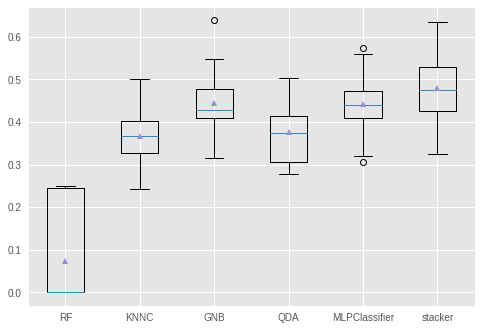

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # suppress warnings for collinearity 

# get a list of models to evaluate and compare
def get_target_models(base_learners, stacker=None, verbose=1):
    models = {} # dict(base_learners)
    for name, estimator in base_learners: 
        if verbose: 
            print(f"[info] Adding {estimator.__class__.__name__}")
        models[name] = estimator
 
    # stacking
    if stacker is None: 
        stacker = ustk.CFStacker(estimators=base_learners, 
                                      final_estimator=LogisticRegression(), # [todo] CF ensemble method
                                      save_itermediate_data=False, 
                                      work_dir = input_dir,
                                      verbose=1)
    models['stacker'] = stacker
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(noise=True)
# get the models to evaluate
models = get_target_models(base_learners) # all base models and the stacker
print(f"[info] n_models={len(models)}")

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Experimental Methods ...
- See `demo-cf-stacking-part2`